In [12]:
!pip install kaggle

In [13]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eceglevgin","key":"9cd4c193c44100d60cfec38f42c18cb3"}'}

In [14]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle datasets download -d nezahatkk/traffic-signs-in-turkiye

Dataset URL: https://www.kaggle.com/datasets/nezahatkk/traffic-signs-in-turkiye
License(s): apache-2.0
 97% 1.45G/1.49G [00:12<00:01, 34.7MB/s]
100% 1.49G/1.49G [00:12<00:00, 132MB/s] 


In [16]:

!unzip -q /content/traffic-signs-in-turkiye.zip -d ./traffic_data


In [17]:
import warnings
warnings.filterwarnings("ignore")


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*32*32, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 16 # Define num_classes before using it
model = SimpleCNN(num_classes).to(device)

In [19]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [20]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class TrafficSignsDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")


        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))
        with open(label_path, "r") as f:
            label = int(f.readline().split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
train_dataset = TrafficSignsDataset(
    img_dir="traffic_data/images/train",
    label_dir="traffic_data/labels/train",
    transform=transform
)

val_dataset = TrafficSignsDataset(
    img_dir="traffic_data/images/val",
    label_dir="traffic_data/labels/val",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("Train set boyutu:", len(train_dataset))
print("Validation set boyutu:", len(val_dataset))
classes = set()
for file in os.listdir("traffic_data/labels/train"):
    with open(os.path.join("traffic_data/labels/train", file)) as f:
        label = int(f.readline().split()[0])
        classes.add(label)

print("Toplam sınıf sayısı:", len(classes))
print("Sınıflar:", classes)

Train set boyutu: 12804
Validation set boyutu: 3201
Toplam sınıf sayısı: 16
Sınıflar: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [22]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [23]:
class TrafficSignsDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")


        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))
        with open(label_path, "r") as f:
            label = int(f.readline().split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label


In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    """Loss ve accuracy grafiklerini çizer.
    :param history: Eğitim geçmişi sözlüğü
    :returns: None
    """
    if not isinstance(history, dict) or not history.get('train_loss'):
        raise ValueError('history sözlüğü boş ya da hatalı.')
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(list(epochs), history['train_loss'], label='Train Loss')
    plt.plot(list(epochs), history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(list(epochs), history['train_acc'], label='Train Acc')
    plt.plot(list(epochs), history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Bir epoch boyunca eğitir.
    :param model: PyTorch modeli
    :param loader: Eğitim DataLoader'ı
    :param criterion: Kayıp fonksiyonu
    :param optimizer: Optimizasyon nesnesi
    :param device: cpu/cuda
    :returns: (ortalama_kayıp, doğruluk_yüzdesi)
    """
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item()) * images.size(0)
        _, preds = outputs.max(1)
        correct += int((preds == labels).sum().item())
        total += int(labels.size(0))
    avg_loss = total_loss / max(1, total)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc


def validate_one_epoch(model, loader, criterion, device):
    """Bir epoch boyunca doğrular.
    :param model: PyTorch modeli
    :param loader: Doğrulama DataLoader'ı
    :param criterion: Kayıp fonksiyonu
    :param device: cpu/cuda
    :returns: (ortalama_kayıp, doğruluk_yüzdesi)
    """
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item()) * images.size(0)
            _, preds = outputs.max(1)
            correct += int((preds == labels).sum().item())
            total += int(labels.size(0))
    avg_loss = total_loss / max(1, total)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc


def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Modeli birkaç epoch eğitir ve geçmişi döner.
    :param model: PyTorch modeli
    :param train_loader: Eğitim DataLoader'ı
    :param val_loader: Doğrulama DataLoader'ı
    :param criterion: Kayıp fonksiyonu
    :param optimizer: Optimizasyon nesnesi
    :param device: cpu/cuda
    :param num_epochs: Epoch sayısı
    :returns: {'train_loss', 'val_loss', 'train_acc', 'val_acc'} listeleri
    """
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc = validate_one_epoch(model, val_loader, criterion, device)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}% "
              f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.2f}%")
    return history

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Epoch 1/20 Train Loss: 1.6049, Train Acc: 50.19% Val Loss: 1.2707, Val Acc: 59.11%
Epoch 2/20 Train Loss: 1.0080, Train Acc: 67.10% Val Loss: 1.2541, Val Acc: 60.17%
Epoch 3/20 Train Loss: 0.7459, Train Acc: 74.72% Val Loss: 1.3322, Val Acc: 59.51%
Epoch 4/20 Train Loss: 0.5560, Train Acc: 81.29% Val Loss: 1.4255, Val Acc: 60.79%
Epoch 5/20 Train Loss: 0.4314, Train Acc: 85.91% Val Loss: 1.4792, Val Acc: 62.01%
Epoch 6/20 Train Loss: 0.3513, Train Acc: 88.75% Val Loss: 1.5127, Val Acc: 62.70%
Epoch 7/20 Train Loss: 0.2986, Train Acc: 90.38% Val Loss: 1.5965, Val Acc: 62.32%
Epoch 8/20 Train Loss: 0.2433, Train Acc: 92.44% Val Loss: 1.7075, Val Acc: 62.01%
Epoch 9/20 Train Loss: 0.2404, Train Acc: 92.48% Val Loss: 1.7853, Val Acc: 62.07%
Epoch 10/20 Train Loss: 0.2158, Train Acc: 93.40% Val Loss: 1.8343, Val Acc: 62.64%
Epoch 11/20 Train Loss: 0.1965, Train Acc: 94.05% Val Loss: 1.9140, Val Acc: 61.26%
Epoch 12/20 Train Loss: 0.1931, Train Acc: 94.20% Val Loss: 1.9242, Val Acc: 60.82%
E

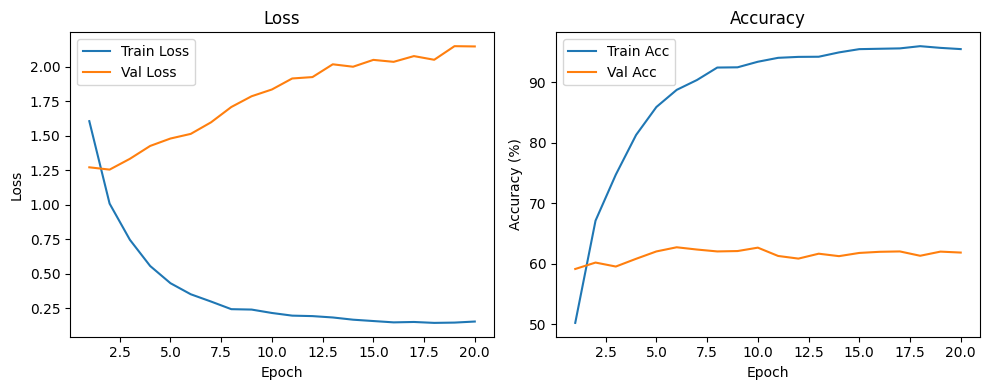

In [27]:
history = train_model(model, train_loader, val_loader,
                      criterion, optimizer, device, num_epochs=20)
plot_history(history)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_and_confusion(model, loader, device, class_names):
    """Modeli doğrular, karmaşıklık matrisi ve sınıflandırma raporu döner.
    :param model: PyTorch modeli
    :param loader: Doğrulama DataLoader'ı
    :param device: cpu/cuda
    :param class_names: Sınıf isimlerinin listesi
    :returns: (gerçek_etiketler, tahmin_etiketler, karmaşıklık_matrisi, sınıflandırma_raporu)
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

    print("Karmaşıklık Matrisi:")
    print(cm)
    print("\nSınıflandırma Raporu:")
    print(cr)

    return y_true, y_pred, cm, cr

In [29]:
class_names = [str(i) for i in range(num_classes)]
y_true, y_pred, cm, cr = evaluate_and_confusion(model, val_loader, device, class_names)

Karmaşıklık Matrisi:
[[ 47   3   0   0   4   9   2   0   0   3   5   2   0   0   0   1]
 [  2  44   3   0  10   2   1   6   1   2  15   9   0   0  18   2]
 [  2   3  79   5   9   5   2   7   1   4   3  14   1   0   6   7]
 [  2   3   0 250  14   3   2   7  16   3   0  19   0  14   5   0]
 [ 12   5   9   9 372   5   3   8   9   7  21  30   0   1  29   5]
 [ 11   5   0   1   5  68   6   4   2   3   6  23   0   0   6   2]
 [  0   0   3   1   7   4  74  11   4   7   0  36   1  10   7   6]
 [  0   3   6   1  10   5   4  42   3   1   4  18   8   0   8   6]
 [  3   1   0   4  10   0   4   1 136  20   0  11   0   1   2   3]
 [  0   1   2   2   9   0   5   6  21  61   0  25   0   6   9   1]
 [  6   5   3   0   9   3   2   0   0   2  61   5   0   0   0   0]
 [  1   4   6   4  15   5   5   6   1  10   6 187   0   4  28   2]
 [  0   0   0   0   0   0   0   1   0   0   1   1   5   0   0   1]
 [  0   0   0  12   1   1   2   0   0   5   1  31   0  38   5   0]
 [  3   9   5   5  40  10   4  10   3  11

Epoch 1/5 Train Loss: 0.2754, Train Acc: 91.67% Val Loss: 2.1646, Val Acc: 60.48%
Epoch 2/5 Train Loss: 0.1881, Train Acc: 94.74% Val Loss: 2.1620, Val Acc: 61.20%
Epoch 3/5 Train Loss: 0.1632, Train Acc: 95.31% Val Loss: 2.2503, Val Acc: 60.70%
Epoch 4/5 Train Loss: 0.1500, Train Acc: 95.65% Val Loss: 2.3307, Val Acc: 60.98%
Epoch 5/5 Train Loss: 0.1563, Train Acc: 95.53% Val Loss: 2.1935, Val Acc: 60.86%


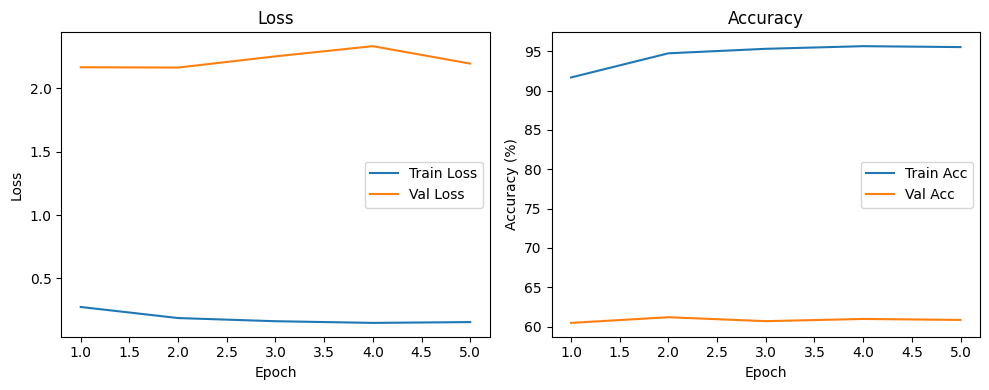

In [31]:
train_loader_bs16 = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_bs16   = DataLoader(val_dataset, batch_size=16, shuffle=False)

history_bs16 = train_model(model, train_loader_bs16, val_loader_bs16,
                           criterion, optimizer, device, num_epochs=5)

plot_history(history_bs16)